# Foraging

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib.colors import ListedColormap
from tqdm import tqdm
import time
from torch import nn
import torch

np.random.seed(42)

# 1 - Grid

## 1.1 - Grid

In [38]:
grid_shape = [7, 7]

grid = np.zeros(grid_shape).astype(int)
print(grid)

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


## 1.2 - Agents

In [39]:
n_agents = 3
agents = list(range(-n_agents,0))

# Getting all empty indexes from the grid: [[0,0], [0,1], ...]
empty_indexes = np.stack(np.where(grid == 0)).T

# Sampling 1 empty index from empty_indexes 
random_i = np.random.choice(range(empty_indexes.shape[0]), n_agents)
agent_idxs = empty_indexes[random_i,:]

# Adding prizes to grid with label 'reward_prize'
for i, idx in enumerate(agent_idxs):
    grid[idx[0], idx[1]] = agents[i]
    
print(grid)

[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [-1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [-2  0  0  0  0  0  0]
 [ 0  0  0 -3  0  0  0]
 [ 0  0  0  0  0  0  0]]


## 1.3 - Apples

In [40]:
possible_values = list(range(1,n_agents+1))
# possible_values = [1]
n_apples = 10

# Symbol for the prize in the grid
symbol_apple = 1

# Getting all empty indexes from the grid: [[0,0], [0,1], ...]
empty_indexes = np.stack(np.where(grid == 0)).T

# Sampling 1 empty index from empty_indexes 
random_i = np.random.choice(range(empty_indexes.shape[0]), n_apples)
prize_idxs = empty_indexes[random_i,:]

# Sampling foraging value
values = np.random.choice(possible_values, n_apples)

# Adding prizes to grid with label 'reward_prize'
for i, idx in enumerate(prize_idxs):
    grid[idx[0], idx[1]] = values[i]
    
print(grid)

[[ 0  0  0  0  0  0  0]
 [ 2  0  0  1  0  0  0]
 [-1  0  0  0  0  2  0]
 [ 1  0  2  1  0  0  0]
 [-2  0  0  0  0  0  0]
 [ 0  0  2 -3  0  0  2]
 [ 0  0  0  3  0  0  0]]


## 1.4 - Functions

#### 1.4.1 - Plotting game

In [41]:
# Function that plots the grid
def plot_game(grid):

    apple_locs = list(set(grid[grid>0]))
    agent_locs = list(set(grid[grid<0]))

    # Defining colors for each symbol
    colors = {0: 'lightgrey'}
    colors.update({loc:'red' for loc in apple_locs})
    colors.update({loc:'cyan' for loc in agent_locs})

    clear_output(wait=True)

    # Convert the matrix values to a list of colors
    unique_values = list(colors.keys())  # Extract unique values in the correct order
    
    color_list = [colors[val] for val in unique_values]  # Generate a list of colors in the order of unique values
    # Create a ListedColormap using the colors
    cmap = ListedColormap(color_list)
    
    # Create an index map to translate values in the matrix to their corresponding indices in the cmap
    index_map = np.vectorize(lambda x: unique_values.index(x))(grid)

    fig, ax = plt.subplots(1, figsize=(5,5))
    
    # Plot the matrix using imshow and the custom colormap
    ax.imshow(index_map, cmap=cmap)

    for (j,i),label in np.ndenumerate(grid):
        if label > 0:
            ax.text(i,j,label,ha='center',va='center', fontsize=14)
        elif label < 0:
            ax.text(i,j,r'$x_{}$'.format(label*-1), ha='center',va='center', fontsize=14)
    plt.axis('off')

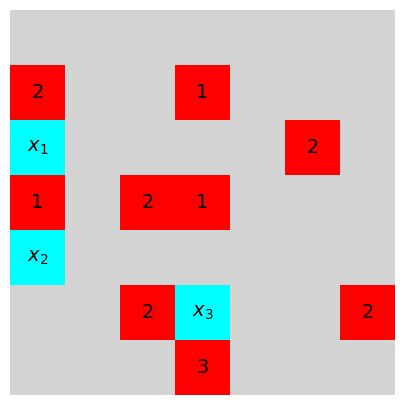

In [42]:
plot_game(grid)

In [43]:
grid_init = np.copy(grid)
def reset():
    return np.copy(grid_init)

#### 1.4.2 - Dynamics 

In [44]:
# Getting the agent's [x,y] coordinates
def get_agent_pos(grid, agent):
    return np.hstack(np.where(grid == agent))

In [45]:
def rand_init(grid):

    pos = np.where(grid<0)
    for i in range(len(pos[0])):
        grid[pos[0][i], pos[1][i]] = 0
    
    # Getting all empty indexes from the grid: [[0,0], [0,1], ...]
    empty_indexes = np.stack(np.where(grid == 0)).T
    
    # Sampling 1 empty index from empty_indexes 
    random_i = np.random.choice(range(empty_indexes.shape[0]), n_agents)
    agent_idxs = empty_indexes[random_i,:]
    
    # Adding prizes to grid with label 'reward_prize'
    for i, idx in enumerate(agent_idxs):
        grid[idx[0], idx[1]] = agents[i]

In [46]:
# Allowed movements
MOVEMENTS = {
    'left': np.array([0,-1]), 
    'down':np.array([1,0]), 
    'right':np.array([0,1]), 
    'up':np.array([-1,0])
}

ACTIONS = list(MOVEMENTS.keys()) + ['collect', 'rest']
ACTIONS

['left', 'down', 'right', 'up', 'collect', 'rest']

In [47]:
# Reward for each time step
reward_timestep = -0.1

In [48]:
NEIGH = [[i,j] for i in [-1,0,1] for j in [-1,0,1]]
NEIGH

[[-1, -1], [-1, 0], [-1, 1], [0, -1], [0, 0], [0, 1], [1, -1], [1, 0], [1, 1]]

In [49]:
def act(action, agent, grid):
    
    # We copy the grid so that our changes dont reflect on the grid
    grid = grid.copy()

    terminate = False

    reward = reward_timestep
    
    # If the action is not allowed (e.g. 'banana'), we raise an error
    if action not in ACTIONS:
        raise ValueError(f'Possible actions are: { ACTIONS }')
    
    # Otherwise, perform movement
    elif action in MOVEMENTS.keys():
        
        # Getting current position of the agent
        curr_pos = get_agent_pos(grid, agent)
        
        # Getting the next position. 
        # Note that if the action would take the agent outside the grid, the agent stays in place.
        next_pos = curr_pos + MOVEMENTS[action]
        next_pos[0] = np.clip(next_pos[0], 0, grid_shape[0]-1)
        next_pos[1] = np.clip(next_pos[1], 0, grid_shape[1]-1)

        if grid[next_pos[0], next_pos[1]] == 0:
            grid[curr_pos[0], curr_pos[1]] = 0
            grid[next_pos[0], next_pos[1]] = agent   
            
    elif action == 'rest':
        pass
        
    elif action == 'collect':

        # Getting current position of the agent
        curr_pos = get_agent_pos(grid, agent)

        for value in sorted(possible_values, reverse=True):
            
            for delta in NEIGH:

                # Getting neighbordhoods
                x = np.clip(curr_pos[0] + delta[0], 0, grid.shape[0]-1)
                y = np.clip(curr_pos[1] + delta[1], 0, grid.shape[1]-1)
                
                if grid[x, y] == value:
                    neigh_agents = []
                    
                    for delta_app in NEIGH:
                        
                        # Getting neighbordhoods
                        x2 = np.clip(x + delta_app[0], 0, grid.shape[0]-1)
                        y2 = np.clip(y + delta_app[1], 0, grid.shape[1]-1)
                        
                        if grid[x2, y2] < 0:
                            neigh_agents.append(grid[x2, y2])
                            
                    neigh_agents = set(neigh_agents)
                    
                    if len(neigh_agents) >= value:
                        reward += 1
                        grid[x,y] = 0
                        break
    if len(grid[grid>0])==0:
        terminate = True
    return (grid, reward, terminate)

In [50]:
def play(policy, n_epis=10, T=100, show_games=False, plot_value=False, rand_init=False):
    
    V = {agent:[] for agent in agents}

    for _ in tqdm(range(n_epis)):
        grid = reset()
        V_epi = {agent:0 for agent in agents}
        for i in range(T):
            actions = policy(grid)
            for j, agent in enumerate((agents)):
                action = actions[j]
                grid,r,terminate = act(action, agent, grid)
                V_epi[agent] += r
                if show_games:
                    time.sleep(0.001)
                    plot_game(grid)
                    plt.title(' || '.join([f'$x_{-agent}$: {round(V_epi[agent],2)}' for agent in sorted(agents, reverse=True)]))
                    plt.show()
                    
                if terminate:
                    return V
        for agent in agents:
            V[agent].append(V_epi[agent])

    if plot_value:
        for agent in agents:
            plt.plot(V[agent], label=f'$x_{-agent}$')
        plt.legend()
        plt.show()
    return V

# 2 - Test Policies

### **Random Policy**

In [51]:
def policy_rand(grid):
    actions = [np.random.choice(ACTIONS) for _ in agents]
    return actions

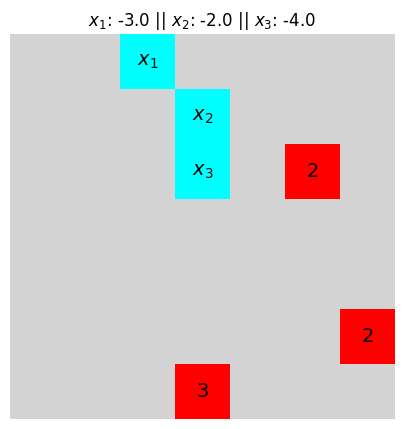

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.21s/it]


In [52]:
V = play(policy_rand, n_epis=1, T=50, show_games=True)

### **$x_1$ Rests**

In [53]:
def policy_rest(grid):
    actions = []
    for agent in agents:
        if agent == -1:
            actions.append('rest')
        else:
            actions.append(np.random.choice(ACTIONS))
    return actions

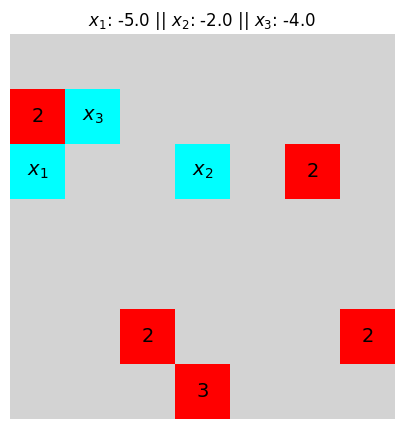

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.42s/it]


In [54]:
V = play(policy_rest, n_epis=1, T=50, show_games=True)

### **$x_1$ 1-Step Lookahead**

In [55]:
def policy_lookahead(grid):
    actions = []
    for agent in agents:
        if agent == -1:
            action = np.random.choice(ACTIONS)
            curr_pos = get_agent_pos(grid, agent)
            for delta in NEIGH:
                # Getting neighbordhoods
                x = np.clip(curr_pos[0] + delta[0], 0, grid.shape[0]-1)
                y = np.clip(curr_pos[1] + delta[1], 0, grid.shape[1]-1)
                if grid[x,y] == 1:
                    action = 'collect'
                    break
            actions.append(action)
        else:
            actions.append(np.random.choice(ACTIONS))
    return actions

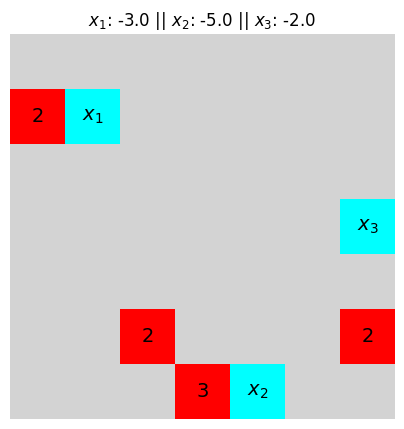

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.20s/it]


In [56]:
V = play(policy_lookahead, n_epis=1, T=50, show_games=True)